<a href="https://colab.research.google.com/github/JohnnyMinx/JohnnyMinx/blob/main/GP_SVRModel.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
# Import all the necessary package
# Both of the first two below are only needed to run the class
!pip install pytrends
!pip install nltk

import pandas as pd
import openpyxl
import numpy as np
from sklearn.preprocessing import MinMaxScaler
import matplotlib.pyplot as plt
import seaborn as sns
from pytrends.request import TrendReq
from pytrends.exceptions import TooManyRequestsError
from sklearn.feature_extraction.text import CountVectorizer
from sklearn.metrics import accuracy_score
import nltk
from nltk.sentiment.vader import SentimentIntensityAnalyzer
from sklearn.model_selection import train_test_split
import requests
import time

#Commented out as following section is also set as df. Can un-comment if the class isn't working for you.
#df = pd.read_excel('/content/Ocado Stock & Trends.xlsx')
#df

In [ ]:
class CreateData:
    def __init__(self, df, keywords, timeframe, geo):
        self.df = df
        self.keywords = keywords
        self.timeframe = timeframe
        self.geo = geo
        self.trends = None

    def format_data(self):
        self.df = self.df.dropna()
        self.df['Next Day Close'] = self.df['Close'].shift(-1)
        self.df = self.df.iloc[:-1]

        numeric_cols = self.df.select_dtypes(include=np.number).columns.tolist()
        numeric_cols.remove('Next Day Close')
        scaler = MinMaxScaler().fit(self.df[numeric_cols])
        df_scaled = scaler.transform(self.df[numeric_cols])
        self.df[numeric_cols] = df_scaled

        return self.df

    def get_trends(self):
        self.keywords = [i.title() for i in self.keywords]

        nltk.download('vader_lexicon')
        sia = SentimentIntensityAnalyzer()

        pytrends = TrendReq(hl='en-Uk', tz=60)

        retries = 5
        delay = 10

        for attempt in range(retries):
            try:
                pytrends.build_payload(self.keywords, timeframe=self.timeframe, geo=self.geo)
                self.trends = pytrends.interest_over_time()
                pd.DataFrame(self.trends)
                numeric_cols = self.trends.select_dtypes(include=np.number).columns.tolist()
                scaler = MinMaxScaler().fit(self.trends[numeric_cols])
                trends_scaled = scaler.transform(self.trends[numeric_cols])
                self.trends[numeric_cols] = trends_scaled
                return self.trends
            except TooManyRequestsError as e:
                print(f"Attempt {attempt + 1}/{retries}: Rate limit exceeded. Retrying in {delay} seconds...")
                time.sleep(delay)
                delay *= 2
            except requests.exceptions.RequestException as e:
                print(f"Request exception: {e}")
                raise e
        raise Exception("Failed to retrieve trends data after multiple attempts")

    def merge_datasets(self, stock_data):
        """
        Required input (param) and output (return) are
            :param stock_data: Stock price data from EIKON
            :param trends: Weekly trends data acquired with PyTrends
            :return: A merged dataset which has the stock price data along with trends search data and keeps the 'New Close Price' as the end column
        """
        # Resetting index for trends data so the date column is no longer used as the index and can instead be used to merge the datasets
        new_trends = self.trends.reset_index()

        # Ensuring both date columns are in datetime format
        stock_data['Exchange Date'] = pd.to_datetime(stock_data['Exchange Date'])
        new_trends['date'] = pd.to_datetime(new_trends['date'])

        # Finding the nearest dates and merging the 'AstraZeneca' column based on these
        stock_data['nearest_date'] = stock_data['Exchange Date'].apply(
            lambda x: new_trends['date'].iloc[(new_trends['date'] - x).abs().argsort()[0]])
        merged_nearest_df = pd.merge(stock_data, new_trends, left_on='nearest_date', right_on='date', how='left')

        # Removing redundant columns
        merged_nearest_df.drop(['nearest_date', 'date', 'isPartial', 'Net', '%Chg', 'Volume', 'Turnover - GBP'], axis=1, inplace=True)

        # Adjusting the columns order to have 'Next Day Close' on the end
        columns = merged_nearest_df.columns.tolist()
        columns.remove('Next Day Close')
        columns.append('Next Day Close')
        merged_nearest_df = merged_nearest_df[columns]

        return merged_nearest_df

    def return_data(self):
        stocks = self.format_data()
        self.get_trends()
        return self.merge_datasets(stocks)

data = pd.read_excel('/content/Ocado Price History.xlsx')

create_data = CreateData(data, ['covid', 'lockdown', 'quarantine'], '2019-03-31 2024-03-27', 'GB')
df = create_data.return_data()
df

<ipython-input-2-3b63f06901c8>:11: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self.df['Next Day Close'] = self.df['Close'].shift(-1)
[nltk_data] Downloading package vader_lexicon to /root/nltk_data...


,Exchange Date,Close,Open,Low,High,Flow,Covid,Lockdown,Quarantine,Next Day Close
0,2024-03-28,0.043776,0.049628,0.043607,0.043120,0.090355,0.01,0.0,0.0,4.665
1,2024-03-27,0.048244,0.045522,0.044449,0.043081,0.098810,0.01,0.0,0.0,4.673
2,2024-03-26,0.048558,0.046148,0.045972,0.052411,0.113229,0.01,0.0,0.0,4.526
3,2024-03-25,0.042797,0.048807,0.042565,0.041866,0.093684,0.01,0.0,0.0,4.683
4,2024-03-22,0.048950,0.051623,0.047655,0.045904,0.107255,0.01,0.0,0.0,4.767
...,...,...,...,...,...,...,...,...,...,...
1254,2019-04-09,0.417620,0.416308,0.423848,0.422383,0.490333,0.00,0.0,0.0,14.045
1255,2019-04-08,0.415857,0.409855,0.416032,0.412583,0.476023,0.00,0.0,0.0,13.910
1256,2019-04-05,0.410566,0.402034,0.407014,0.407683,0.462884,0.00,0.0,0.0,13.700
1257,2019-04-04,0.402336,0.403989,0.412024,0.405723,0.448366,0.00,0.0,0.0,13.680


In [ ]:
# Code for merging the Google Trends columns in to one.
# It takes a mean average for each row of the trends columns (columns 6, 7, & 8) and then removes them to leave just one column which summarises the trends.

# Creates column of average trends values (for each row of Trends columns, add them up then divided by 3).
interaction = (df.iloc[:, 6] + df.iloc[:, 7] + df.iloc[:, 8]) / 3

# Adds the new column (interaction) to the df at index -1 (the last column) and with the name 'Trends'.
df.insert(len(data.columns) - 1, 'Trends', interaction)

# Defines the columns to drop (the 3 original Google Trends data columns) now that the averages one is added.
columns_to_drop = df.columns[6:9]

# Removes these columns.
df.drop(columns=columns_to_drop, inplace=True)

# Displays df now that there is only one column for trends data
df

,Exchange Date,Close,Open,Low,High,Flow,Trends,Next Day Close
0,2024-03-28,0.043776,0.049628,0.043607,0.043120,0.090355,0.003333,4.665
1,2024-03-27,0.048244,0.045522,0.044449,0.043081,0.098810,0.003333,4.673
2,2024-03-26,0.048558,0.046148,0.045972,0.052411,0.113229,0.003333,4.526
3,2024-03-25,0.042797,0.048807,0.042565,0.041866,0.093684,0.003333,4.683
4,2024-03-22,0.048950,0.051623,0.047655,0.045904,0.107255,0.003333,4.767
...,...,...,...,...,...,...,...,...
1254,2019-04-09,0.417620,0.416308,0.423848,0.422383,0.490333,0.000000,14.045
1255,2019-04-08,0.415857,0.409855,0.416032,0.412583,0.476023,0.000000,13.910
1256,2019-04-05,0.410566,0.402034,0.407014,0.407683,0.462884,0.000000,13.700
1257,2019-04-04,0.402336,0.403989,0.412024,0.405723,0.448366,0.000000,13.680


In [ ]:
from sklearn.model_selection import train_test_split

df['Exchange Date'] = pd.to_datetime(df['Exchange Date'])

# Sort the DataFrame based on the date
df_sorted = df.sort_values(by='Exchange Date')

train_size=0.8
test_size=0.1
val_size=0.1
assert train_size + test_size + val_size == 1, "Proportions must sum to 1"

# Calculate the number of samples for each set
total_samples = len(df_sorted)
train_end_idx = int(total_samples * train_size)
test_end_idx = train_end_idx + int(total_samples * test_size)

# Split the dataset into training, testing, and validation sets
train_data = df_sorted.iloc[:train_end_idx]
test_data = df_sorted.iloc[train_end_idx:test_end_idx]
val_data = df_sorted.iloc[test_end_idx:]

print("Training data length:", len(train_data))
print("Testing data length:", len(test_data))
print("Validating data length:", len(val_data))

# Define features and target
X_train = train_data.iloc[:, 1:9]
y_train = train_data.iloc[:, -1]
X_test = test_data.iloc[:, 1:9]
y_test = test_data.iloc[:, -1]
X_val = val_data.iloc[:, 1:9]
y_val = val_data.iloc[:, -1]

Training data length: 1007
Testing data length: 125
Validating data length: 127


In [ ]:
import pandas as pd
import numpy as np
import time
from sklearn.svm import SVR
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import GridSearchCV
from sklearn.metrics import mean_squared_error, mean_absolute_percentage_error, r2_score
import matplotlib.pyplot as plt

# Extracting the features and target variable
X_train = train_data.drop(columns=['Exchange Date', 'Next Day Close'])
y_train = train_data['Next Day Close']
X_val = val_data.drop(columns=['Exchange Date', 'Next Day Close'])
y_val = val_data['Next Day Close']
X_test = test_data.drop(columns=['Exchange Date', 'Next Day Close'])
y_test = test_data['Next Day Close']

# Standardize the data
scaler_X = StandardScaler()
scaler_y = StandardScaler()

X_train_scaled = scaler_X.fit_transform(X_train)
y_train_scaled = scaler_y.fit_transform(y_train.values.reshape(-1, 1)).flatten()
X_val_scaled = scaler_X.transform(X_val)
y_val_scaled = scaler_y.transform(y_val.values.reshape(-1, 1)).flatten()
X_test_scaled = scaler_X.transform(X_test)
y_test_scaled = scaler_y.transform(y_test.values.reshape(-1, 1)).flatten()

# Set the best parameters using grid search
best_params = {'C': 100, 'epsilon': 0.01, 'gamma': 0.01}

# Measure training time
start_time = time.time()
svr_best = SVR(kernel='rbf', C=best_params['C'], epsilon=best_params['epsilon'], gamma=best_params['gamma'])
svr_best.fit(X_train_scaled, y_train_scaled)
training_time = time.time() - start_time

# Measure validation prediction time
start_time = time.time()
y_val_pred_scaled = svr_best.predict(X_val_scaled)
validation_time = time.time() - start_time

# Measure test prediction time
start_time = time.time()
y_test_pred_scaled = svr_best.predict(X_test_scaled)
testing_time = time.time() - start_time

# Inverse transform the predictions
y_val_pred = scaler_y.inverse_transform(y_val_pred_scaled.reshape(-1, 1)).flatten()
y_val_true = scaler_y.inverse_transform(y_val_scaled.reshape(-1, 1)).flatten()
y_test_pred = scaler_y.inverse_transform(y_test_pred_scaled.reshape(-1, 1)).flatten()
y_test_true = scaler_y.inverse_transform(y_test_scaled.reshape(-1, 1)).flatten()

# Calculate evaluation metrics for validation and test sets
val_mse = mean_squared_error(y_val_true, y_val_pred)
val_mape = mean_absolute_percentage_error(y_val_true, y_val_pred)
val_r2 = r2_score(y_val_true, y_val_pred)

test_mse = mean_squared_error(y_test_true, y_test_pred)
test_mape = mean_absolute_percentage_error(y_test_true, y_test_pred)
test_r2 = r2_score(y_test_true, y_test_pred)

In [ ]:
print("Training data length:", len(train_data))
print("Testing data length:", len(test_data))
print("Validating data length:", len(val_data))

Training data length: 1007
Testing data length: 125
Validating data length: 127


In [ ]:
print(f'Training Time: {training_time} seconds')
print(f'Validation Prediction Time: {validation_time} seconds')
print(f'Test Prediction Time: {testing_time} seconds')

Training Time: 0.4924342632293701 seconds
Validation Prediction Time: 0.007932186126708984 seconds
Test Prediction Time: 0.0076770782470703125 seconds


In [ ]:
print(f'Validation MSE: {val_mse}')
print(f'Validation MAPE: {val_mape}')
print(f'Validation R² Score: {val_r2}')

Validation MSE: 0.0070769519604466985
Validation MAPE: 0.011361394376977352
Validation R² Score: 0.9902424499620321


In [ ]:
print(f'Test MSE: {test_mse}')
print(f'Test MAPE: {test_mape}')
print(f'Test R² Score: {test_r2}')

Test MSE: 0.011022159066357718
Test MAPE: 0.012616526739313039
Test R² Score: 0.9963325298231034


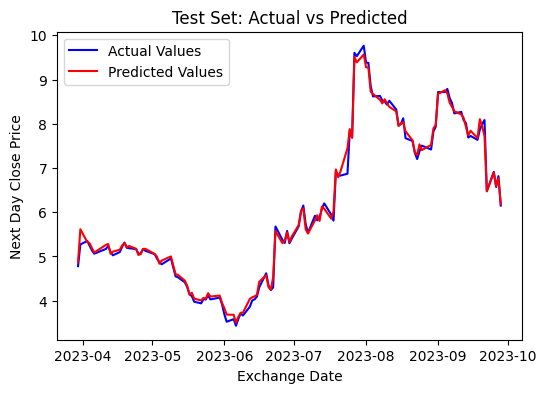

In [ ]:
# Plotting the results for the test set
plt.figure(figsize=(6, 4))
plt.plot(test_data['Exchange Date'], y_test_true, label='Actual Values', color='b')
plt.plot(test_data['Exchange Date'], y_test_pred, label='Predicted Values', color='r')
plt.xlabel('Exchange Date')
plt.ylabel('Next Day Close Price')
plt.title('Test Set: Actual vs Predicted')
plt.legend()
plt.show()

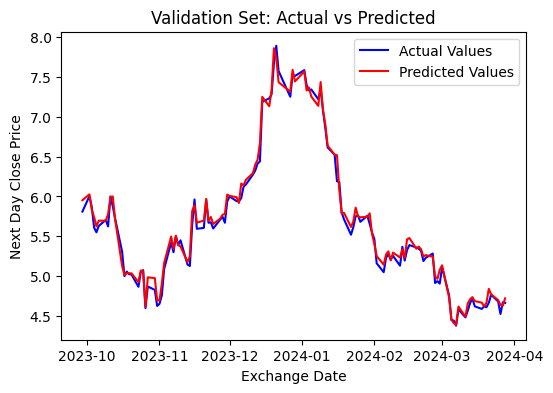

In [ ]:
# Plotting the results for the validation set
plt.figure(figsize=(6, 4))
plt.plot(val_data['Exchange Date'], y_val_true, label='Actual Values', color='b')
plt.plot(val_data['Exchange Date'], y_val_pred, label='Predicted Values', color='r')
plt.xlabel('Exchange Date')
plt.ylabel('Next Day Close Price')
plt.title('Validation Set: Actual vs Predicted')
plt.legend()
plt.show()

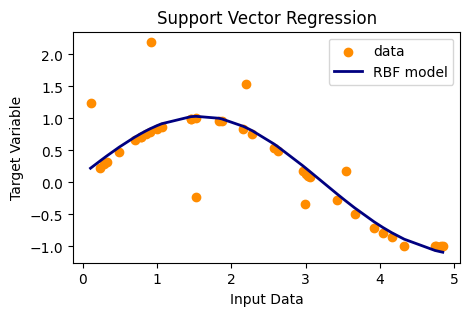

In [ ]:
import numpy as np
import matplotlib.pyplot as plt
from sklearn.svm import SVR

# Generate synthetic data
np.random.seed(42)
X = np.sort(5 * np.random.rand(40, 1), axis=0)
y = np.sin(X).ravel()
y[::5] += 3 * (0.5 - np.random.rand(8))

# Fit regression model
svr_rbf = SVR(kernel='rbf', C=100, gamma=0.1, epsilon=0.1)
y_rbf = svr_rbf.fit(X, y).predict(X)

# Create a plot
plt.figure(figsize=(5, 3))
plt.scatter(X, y, color='darkorange', label='data')
plt.plot(X, y_rbf, color='navy', lw=2, label='RBF model')
plt.xlabel('Input Data')
plt.ylabel('Target Variable')
plt.title('Support Vector Regression')
plt.legend()
plt.show()

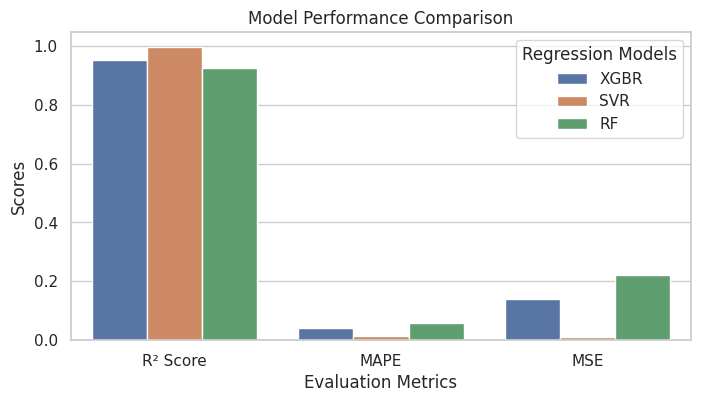

In [ ]:
import matplotlib.pyplot as plt
import seaborn as sns
import pandas as pd

# Create the data
data = {
    'Regression Models': ['XGBR', 'SVR', 'RF'],
    'R² Score': [0.953, 0.996, 0.926],
    'MAPE': [0.041, 0.013, 0.059],
    'MSE': [0.14, 0.011, 0.22]
}

# Convert to DataFrame
df = pd.DataFrame(data)

# Melt the DataFrame for easier plotting with seaborn
df_melted = df.melt(id_vars='Regression Models', var_name='Metric', value_name='Value')

# Set the plot style
plt.figure(figsize=(8, 4))
sns.set(style="whitegrid")

# Create the bar plot
sns.barplot(x='Metric', y='Value', hue='Regression Models', data=df_melted)

# Set the title and labels
plt.title('Model Performance Comparison')
plt.xlabel('Evaluation Metrics')
plt.ylabel('Scores')

# Show plot
plt.legend(title='Regression Models')
plt.show()
